In [1]:
import numpy as np
import pandas as pd
import pickle
import numpy as np
import random
import time
import os
#os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,40).__str__()
import cv2
from tqdm import tqdm

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from keras import optimizers
#from sklearn.metrics import classification_report, confusion_matrix
import sklearn
import seaborn as sn
from keras.callbacks import CSVLogger, LambdaCallback
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install kaggle

In [5]:
!mkdir ~/.kaggle

In [6]:

!cp /content/drive/MyDrive/Project_482/kaggle.json ~/.kaggle/


In [7]:
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d farjanakabirsamanta/alzheimer-diseases-3-class


 68% 33.0M/48.7M [00:00<00:00, 87.0MB/s]
100% 48.7M/48.7M [00:00<00:00, 101MB/s] 


In [9]:
!unzip /content/alzheimer-diseases-3-class.zip


Streaming output truncated to the last 5000 lines.
  inflating: 3_cls/train/AD/AD_2328.png  
  inflating: 3_cls/train/AD/AD_2329.png  
  inflating: 3_cls/train/AD/AD_233.png  
  inflating: 3_cls/train/AD/AD_2330.png  
  inflating: 3_cls/train/AD/AD_2331.png  
  inflating: 3_cls/train/AD/AD_2332.png  
  inflating: 3_cls/train/AD/AD_2333.png  
  inflating: 3_cls/train/AD/AD_2334.png  
  inflating: 3_cls/train/AD/AD_2335.png  
  inflating: 3_cls/train/AD/AD_2336.png  
  inflating: 3_cls/train/AD/AD_2337.png  
  inflating: 3_cls/train/AD/AD_2338.png  
  inflating: 3_cls/train/AD/AD_2339.png  
  inflating: 3_cls/train/AD/AD_234.png  
  inflating: 3_cls/train/AD/AD_2340.png  
  inflating: 3_cls/train/AD/AD_2341.png  
  inflating: 3_cls/train/AD/AD_2342.png  
  inflating: 3_cls/train/AD/AD_2343.png  
  inflating: 3_cls/train/AD/AD_2344.png  
  inflating: 3_cls/train/AD/AD_2345.png  
  inflating: 3_cls/train/AD/AD_2346.png  
  inflating: 3_cls/train/AD/AD_2347.png  
  inflating: 3_cls/train/AD

In [10]:
#frameRate = 1
base_dir = f'/content/3_cls'


#train_dir = os.path.join(base_dir) #, 'train_patch'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'test')
test_dir = os.path.join(base_dir, 'test')

work_dir = "./"
color_type = 'rgb' # rgb, grayscale
BATCH_SIZE = 64
#validation_split = 0.5
img_dim = (256,256)
#list_classes = ['Monocot_Eichhornia','Monocot_Musa'] #'Monocot_Cocos',

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   #rotation_range=90,
                                   #validation_split=validation_split
                                   )
val_datagen = ImageDataGenerator(rescale=1./255,
                                #validation_split=validation_split
                                )
test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_dim,
        batch_size=BATCH_SIZE,
        color_mode=color_type, # grayscale, rgb
        class_mode='categorical',
        interpolation='lanczos',
        #classes=list_classes,
        #subset='training'
        )

Found 6477 images belonging to 3 classes.


In [13]:
num_classes = train_generator.num_classes
total_train_data = train_generator.samples

print(f"total_train_data = {total_train_data}")
print(f"train_generator.image_shape = {train_generator.image_shape}")
print(f"num_classes = {num_classes}")

total_train_data = 6477
train_generator.image_shape = (256, 256, 3)
num_classes = 3


In [14]:
val_generator = val_datagen.flow_from_directory(
        val_dir,
        shuffle=False,
        target_size=img_dim,
        batch_size=BATCH_SIZE,
        color_mode=color_type, # grayscale, rgb
        class_mode='categorical',
        interpolation='lanczos',
        #classes=list_classes,
        #subset='validation'
        )

Found 1362 images belonging to 3 classes.


In [15]:
total_val_data = val_generator.samples
print(f"total_val_data = {total_val_data}")

total_val_data = 1362


In [16]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        shuffle=False,
        target_size=img_dim,
        batch_size=BATCH_SIZE,
        color_mode=color_type, # grayscale, rgb
        class_mode='categorical',
        interpolation='lanczos',
        #classes=list_classes,
        #subset='validation'
        )

Found 1362 images belonging to 3 classes.


In [17]:
total_test_data = test_generator.samples
print(f"total_test_data = {total_test_data}")

total_test_data = 1362


In [20]:
# DenseNet121 ResNet101 ResNet50 DenseNet201 InceptionV3 Xception NASNetLarge ResNet152V2 InceptionResNetV2 EfficientNetB7
model_name = "MobileNetV2"
impl_type = f"TL.3D.{model_name}" # TransferLearning3D
dataset = f"15_Class_Normal.{color_type}.{train_generator.image_shape[1]}p" # +str(img_size)+"p"
dataset

'15_Class_Normal.rgb.256p'

In [21]:
#'''
count_no_improvement = 0
epoch_initial = True
#'''

In [22]:
#NUM_NEURONS = 16
#NUM_LAYERS = 3
#BATCH_SIZE = 16 # 10
NUM_EPOCHS = 50
epochs_completed = 0
LEARNING_RATE = 0.0001
EPSILON = 1e-5
early_stop_after_epochs = 10
DROPOUT = 0.5 # 0.5 0.0
pad = 0

LOSS = 'categorical_crossentropy'
ACTIVATION_FUNCTION = 'relu' # relu sigmoid elu
FINAL_ACTIVATION_FUNCTION = 'softmax'
validation_split = 0.1
kernel_size=(1,1)
pointTrainableAfter = "allDefault" # "allDefault", "allFalse", 160, 170
OPTIMIZER = "Adam" # Adam SGD RMSProp
init_weights = "imagenet" # "imagenet" None
modelExt = "" #.Dense.1024.1024.2048 .Dense.128.256.512, .512.512.512 .Dense.512.512.512.512.Res
l2_val = 0.001

# +"_kernel"+str(kernel_size)+"_lr"+str(LEARNING_RATE)+"_batch"+str(BATCH_SIZE)+"_epochs"+str(NUM_EPOCHS)
#checkpointer_name  = "weights_"+dataset+"_"+impl_type+"_nLayers"+str(NUM_LAYERS)+"_nNeurons"+str(NUM_NEURONS)+".hdf5"
ext = f"" #.Flatten.l2.{str(l2_val)}.run_1 run_1 run_2 .DropAfter .momentum0.9
#'''
checkpointer_name  = "weights."+dataset+"."+impl_type+".wInit."+str(init_weights)+".TrainableAfter."+str(pointTrainableAfter)+\
                     ".lr"+str(LEARNING_RATE)+".opt."+OPTIMIZER+".batch"+str(BATCH_SIZE)+ext+".hdf5"
log_name = "log."+checkpointer_name[8:-5]+".log"

print('checkpointer_name =', checkpointer_name)
print('log_name =', log_name)
#'''

checkpointer_name = weights.15_Class_Normal.rgb.256p.TL.3D.MobileNetV2.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64.hdf5
log_name = log.15_Class_Normal.rgb.256p.TL.3D.MobileNetV2.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64.log


In [23]:
train_generator.image_shape

(256, 256, 3)

In [24]:
#'''
#base_model=DenseNet121(weights=None, include_top=False, input_shape=np_train_dataset2.shape[1:]) # `None` (random initialization)
#base_model=ResNet152V2(weights=None, include_top=False, input_shape=np_train_dataset2.shape[1:])
# ResNet152V2 ResNet50 ResNet101 ResNet152 DenseNet201 InceptionV3 Xception NASNetLarge 'imagenet' DenseNet121
#inputs = Input(final_train_imageset.shape[1:])
#x = ZeroPadding2D(padding=(pad,pad))(inputs)
#base_model=tf.keras.applications.ResNet50(weights=init_weights, include_top=False, input_tensor=x)

inputs = train_generator.image_shape
if model_name == 'ResNet50':
    base_model=tf.keras.applications.ResNet50(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'ResNet101':
    base_model=tf.keras.applications.ResNet101(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'ResNet152':
    base_model=tf.keras.applications.ResNet152(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'ResNet50V2':
    base_model=tf.keras.applications.ResNet50V2(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'ResNet101V2':
    base_model=tf.keras.applications.ResNet101V2(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'ResNet152V2':
    base_model=tf.keras.applications.ResNet152V2(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'InceptionV3':
    base_model=tf.keras.applications.InceptionV3(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'MobileNet':
    base_model=tf.keras.applications.MobileNet(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'MobileNetV2':
    base_model=tf.keras.applications.MobileNetV2(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'Xception':
    base_model=tf.keras.applications.Xception(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'NASNetMobile':
    base_model=tf.keras.applications.NASNetMobile(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'NASNetLarge':
    base_model=tf.keras.applications.NASNetLarge(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'InceptionResNetV2':
    base_model=tf.keras.applications.InceptionResNetV2(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'VGG16':
    base_model=tf.keras.applications.VGG16(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'VGG19':
    base_model=tf.keras.applications.VGG19(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'DenseNet121':
    base_model=tf.keras.applications.DenseNet121(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'DenseNet169':
    base_model=tf.keras.applications.DenseNet169(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'DenseNet201':
    base_model=tf.keras.applications.DenseNet201(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'EfficientNetB0':
    base_model=tf.keras.applications.EfficientNetB0(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'EfficientNetB1':
    base_model=tf.keras.applications.EfficientNetB1(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'EfficientNetB2':
    base_model=tf.keras.applications.EfficientNetB2(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'EfficientNetB3':
    base_model=tf.keras.applications.EfficientNetB3(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'EfficientNetB4':
    base_model=tf.keras.applications.EfficientNetB4(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'EfficientNetB5':
    base_model=tf.keras.applications.EfficientNetB5(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'EfficientNetB6':
    base_model=tf.keras.applications.EfficientNetB6(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'EfficientNetB7':
    base_model=tf.keras.applications.EfficientNetB7(weights=init_weights, include_top=False, input_shape=inputs)
    print(f"model_name = {model_name}")

x=base_model.output
#x = Activation(ACTIVATION_FUNCTION)(x)
x = Flatten()(x)
'''
x = Dense(1024,activation='elu')(x)
x = Dense(512,activation='elu')(x)
x = Dense(512,activation='elu')(x)
#'''
outputs=Dense(num_classes,activation='softmax')(x)

model=Model(inputs=base_model.input,outputs=outputs)
#model.summary()

print(f"model_name = {model_name}")
#'''

9406464/9406464 [==============================] - 0s 0us/step
model_name = MobileNetV2


In [25]:
'''
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=64
)
#'''

"\ntf.keras.utils.plot_model(\n    model, to_file='model.png', show_shapes=True, show_dtype=False,\n    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=64\n)\n#"

In [26]:
#layer_names=[layer.name for layer in base_model.layers]
num_layers_base_model = len(base_model.layers)
num_layers_model = len(model.layers)

print(f"num_layers_base_model = {num_layers_base_model}")
print(f"num_layers_model = {num_layers_model}")

count_trainable = 0
count_non_trainable = 0

#'''
if pointTrainableAfter == "allDefault":
    for layer in base_model.layers:
        layer.trainable=True
        count_trainable += 1
elif pointTrainableAfter == "allFalse":
    for layer in base_model.layers:
        layer.trainable=False
        count_non_trainable += 1
elif pointTrainableAfter > 0:
    for layer in base_model.layers[:pointTrainableAfter]: # [:-pointTrainableAfter]
        layer.trainable=False
        count_non_trainable += 1
    for layer in base_model.layers[pointTrainableAfter:]: # [-pointTrainableAfter:]
        layer.trainable=True
        count_trainable += 1
#'''

'''
for layer in model.layers:
    layer.trainable=True
    count_trainable += 1
#'''

print("count_non_trainable =", count_non_trainable)
print("count_trainable =", num_layers_model-count_non_trainable)
print("Total number of layers =", num_layers_model)

num_layers_base_model = 154
num_layers_model = 156
count_non_trainable = 0
count_trainable = 156
Total number of layers = 156


In [27]:
# "RMSProp" "SGD" "Adam" "Adamax" "Adadelta" "Adagrad" "SGD"
#optimizer = tf.keras.optimizers.RMSprop(lr = LEARNING_RATE, epsilon=EPSILON)

if OPTIMIZER == "RMSProp":
    optimizer = tf.keras.optimizers.RMSprop(learning_rate = LEARNING_RATE, epsilon=EPSILON)
elif OPTIMIZER == "Adam":
    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE, epsilon=EPSILON, beta_1=0.9, beta_2=0.999)
elif OPTIMIZER == "Adamax":
    optimizer = tf.keras.optimizers.Adamax(learning_rate = LEARNING_RATE, epsilon=EPSILON, beta_1=0.9, beta_2=0.999)
elif OPTIMIZER == "Adadelta":
    optimizer = tf.keras.optimizers.Adadelta(learning_rate = LEARNING_RATE, epsilon=EPSILON, rho=0.95)
elif OPTIMIZER == "Adagrad":
    optimizer = tf.keras.optimizers.Adagrad(learning_rate = LEARNING_RATE, epsilon=EPSILON, initial_accumulator_value=0.1)
elif OPTIMIZER == "SGD":
    optimizer = tf.keras.optimizers.SGD(learning_rate = LEARNING_RATE, momentum=0.9)

model.compile(
    #optimizer=OPTIMIZER,
    optimizer=optimizer,
    loss=LOSS,
    metrics=['accuracy']
)

print("OPTIMIZER =", OPTIMIZER)

OPTIMIZER = Adam


In [28]:
# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath = work_dir+checkpointer_name,
                               #monitor='val_accuracy',
                               monitor='val_loss',
                               save_weights_only=False,
                               mode='auto',
                               verbose = 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                               save_best_only =False
                               )
checkpointer_best = ModelCheckpoint(filepath = work_dir+"best_"+checkpointer_name,
                                    monitor='val_loss',
                                    save_weights_only=False,
                                    mode='auto',
                                    verbose = 1,
                                    save_best_only = True
                                    )
early_stopping = EarlyStopping(monitor='val_accuracy', patience=early_stop_after_epochs)

In [29]:
'''
if 'count_no_improvement' not in globals():
    count_no_improvement = 0
    print("count_no_improvement =", count_no_improvement)
#'''
'''
count_no_improvement = 0 # 0
epoch_initial = False
#'''
min_delta = 0.0009
print("count_no_improvement =", count_no_improvement)

def checkBestPerformance(epoch, logs):
    save_filepath = work_dir+"best_"+checkpointer_name

    global epoch_initial
    #print(f"epoch_initial = {epoch_initial}")
    if epoch_initial == True:
        epoch_initial = False
        model.save(filepath = save_filepath)
        print(". Model saved!")

    elif epoch_initial == False:
        global count_no_improvement

        log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['val_loss', 'val_accuracy'], engine='python')
        min_val_loss = float(str(min(log_data.val_loss.values))[:6])
        max_val_acc = float(str(max(log_data.val_accuracy.values))[:6])

        current_val_acc = float(str(logs['val_accuracy'])[:6])
        current_val_loss = float(str(logs['val_loss'])[:6])

        if (current_val_loss < min_val_loss) and (abs(current_val_loss-min_val_loss) >= min_delta):
            count_no_improvement = 0
            model.save(filepath = save_filepath)
            print("\nval_loss decreased from",min_val_loss," to",current_val_loss,"( val_accuracy =",current_val_acc,").")

        elif (current_val_loss==min_val_loss) and (current_val_acc>max_val_acc):
            count_no_improvement = 0
            model.save(filepath = save_filepath)
            print("\nval_accuracy increased to", current_val_acc, ".")

        else:
            count_no_improvement += 1
            print(". count_no_improvement =", count_no_improvement)

        if count_no_improvement >= early_stop_after_epochs-1:
            global list_callbacks
            del list_callbacks, count_no_improvement
            #print("count_no_improvement =", count_no_improvement, "... list_callbacks =", list_callbacks)

count_no_improvement = 0


In [30]:
epochs_completed = 0
list_callbacks = []
csv_logger = CSVLogger(work_dir+log_name, separator=',', append=True)

#if 'list_callbacks' in globals():
#    del list_callbacks

try:
    log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['epoch'], engine='python')
    epochs_completed = log_data.shape[0]

    #if epochs_completed > 0:
    model = load_model(work_dir+checkpointer_name)
    list_callbacks = [checkpointer, LambdaCallback(on_epoch_end=checkBestPerformance), csv_logger]
    print("epochs_completed =", epochs_completed)

except Exception as error:
    if epochs_completed == 0:
        # list_callbacks = [checkpointer, checkpointer_best, csv_logger, early_stopping]
        list_callbacks = [checkpointer, LambdaCallback(on_epoch_end=checkBestPerformance), csv_logger]
        print("epochs_completed =", epochs_completed)
    elif epochs_completed > 0:
        print(error)

print('checkpointer_name =', checkpointer_name)

epochs_completed = 0
checkpointer_name = weights.15_Class_Normal.rgb.256p.TL.3D.MobileNetV2.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64.hdf5


In [31]:
print('checkpointer_name =', checkpointer_name)
print("Previously completed epochs =", epochs_completed)
print("count_no_improvement =", count_no_improvement, "\n")

#'''
try:
    start_time = time.time()
    history = model.fit(train_generator,
                        steps_per_epoch=total_train_data // BATCH_SIZE,
                        shuffle=True,
                        epochs = NUM_EPOCHS - epochs_completed,
                        validation_data=val_generator,
                        validation_steps=total_val_data // BATCH_SIZE,
                        callbacks=list_callbacks
                        )
    elapsed_time = time.time() - start_time
    print("\nTime elapsed: ", elapsed_time)
except Exception as error:
    print("\nError:", error)
#'''

checkpointer_name = weights.15_Class_Normal.rgb.256p.TL.3D.MobileNetV2.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64.hdf5
Previously completed epochs = 0
count_no_improvement = 0 

Epoch 1/50
101/101 [==============================] - ETA: 0s - loss: 0.6895 - accuracy: 0.7295
Epoch 1: saving model to ./weights.15_Class_Normal.rgb.256p.TL.3D.MobileNetV2.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


. Model saved!
101/101 [==============================] - 80s 450ms/step - loss: 0.6895 - accuracy: 0.7295 - val_loss: 0.7995 - val_accuracy: 0.6369
Epoch 2/50
101/101 [==============================] - ETA: 0s - loss: 0.1491 - accuracy: 0.9428
Epoch 2: saving model to ./weights.15_Class_Normal.rgb.256p.TL.3D.MobileNetV2.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64.hdf5
. count_no_improvement = 1
101/101 [==============================] - 43s 421ms/step - loss: 0.1491 - accuracy: 0.9428 - val_loss: 2.0557 - val_accuracy: 0.5007
Epoch 3/50
101/101 [==============================] - ETA: 0s - loss: 0.0308 - accuracy: 0.9919
Epoch 3: saving model to ./weights.15_Class_Normal.rgb.256p.TL.3D.MobileNetV2.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


. count_no_improvement = 2
101/101 [==============================] - 47s 468ms/step - loss: 0.0308 - accuracy: 0.9919 - val_loss: 1.3065 - val_accuracy: 0.5365
Epoch 4/50
101/101 [==============================] - ETA: 0s - loss: 0.0144 - accuracy: 0.9992
Epoch 4: saving model to ./weights.15_Class_Normal.rgb.256p.TL.3D.MobileNetV2.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


. count_no_improvement = 3
101/101 [==============================] - 44s 435ms/step - loss: 0.0144 - accuracy: 0.9992 - val_loss: 1.3149 - val_accuracy: 0.5409
Epoch 5/50
101/101 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 0.9998
Epoch 5: saving model to ./weights.15_Class_Normal.rgb.256p.TL.3D.MobileNetV2.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


. count_no_improvement = 4
101/101 [==============================] - 43s 426ms/step - loss: 0.0048 - accuracy: 0.9998 - val_loss: 1.4292 - val_accuracy: 0.5402
Epoch 6/50
101/101 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 0.9998
Epoch 6: saving model to ./weights.15_Class_Normal.rgb.256p.TL.3D.MobileNetV2.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


. count_no_improvement = 5
101/101 [==============================] - 43s 424ms/step - loss: 0.0033 - accuracy: 0.9998 - val_loss: 1.6673 - val_accuracy: 0.5179
Epoch 7/50
101/101 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000
Epoch 7: saving model to ./weights.15_Class_Normal.rgb.256p.TL.3D.MobileNetV2.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


. count_no_improvement = 6
101/101 [==============================] - 49s 486ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.6471 - val_accuracy: 0.5312
Epoch 8/50
101/101 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000
Epoch 8: saving model to ./weights.15_Class_Normal.rgb.256p.TL.3D.MobileNetV2.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


. count_no_improvement = 7
101/101 [==============================] - 46s 455ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.7524 - val_accuracy: 0.5320
Epoch 9/50
101/101 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 0.9998
Epoch 9: saving model to ./weights.15_Class_Normal.rgb.256p.TL.3D.MobileNetV2.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


. count_no_improvement = 8
101/101 [==============================] - 49s 481ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 1.4767 - val_accuracy: 0.5662
Epoch 10/50
101/101 [==============================] - ETA: 0s - loss: 8.9108e-04 - accuracy: 1.0000
Epoch 10: saving model to ./weights.15_Class_Normal.rgb.256p.TL.3D.MobileNetV2.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


. count_no_improvement = 9
101/101 [==============================] - 49s 487ms/step - loss: 8.9108e-04 - accuracy: 1.0000 - val_loss: 1.4362 - val_accuracy: 0.5692
Epoch 11/50
101/101 [==============================] - ETA: 0s - loss: 7.2261e-04 - accuracy: 1.0000
Epoch 11: saving model to ./weights.15_Class_Normal.rgb.256p.TL.3D.MobileNetV2.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Error: name 'count_no_improvement' is not defined


In [32]:

csv_logger = CSVLogger(work_dir+log_name, separator=',', append=True)
log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['epoch'], engine='python')
epochs_completed = log_data.shape[0]

result = model.evaluate(test_generator, steps=total_test_data // BATCH_SIZE)
print("Test Acc: {}, Test Loss: {}: ep{}, {}\n".format(round(result[1],4), round(result[0],4), epochs_completed, checkpointer_name))


21/21 [==============================] - 7s 315ms/step - loss: 1.4091 - accuracy: 0.5699
Test Acc: 0.5699, Test Loss: 1.4091: ep10, weights.15_Class_Normal.rgb.256p.TL.3D.MobileNetV2.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64.hdf5



In [33]:
#checkpointer_name = "weights.Fashion.DenseNet121.wInit.None.TrainableAfterallDefault.opt.SGD.drop.0.0.batch32.Flatten.run_1.hdf5"
model_loaded = load_model(work_dir+"best_"+checkpointer_name)
print("Loaded "+work_dir+"best_"+checkpointer_name+".")

Loaded ./best_weights.15_Class_Normal.rgb.256p.TL.3D.MobileNetV2.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64.hdf5.


In [34]:

csv_logger = CSVLogger(work_dir+log_name, separator=',', append=True)
log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['epoch'], engine='python')
epochs_completed = log_data.shape[0]
#'''

result2 = model_loaded.evaluate(test_generator, steps=total_test_data // BATCH_SIZE)
#print("nLayers: {}, nNeurons: {}, DROPOUT: {}, Test Acc: {}, Test Loss: {}".format(NUM_LAYERS, NUM_NEURONS, DROPOUT, round(result2[1], 4), round(result2[0], 4)))
print("Test Acc: {}, Test Loss: {}: ep{}, {}\n".format(round(result2[1],4), round(result2[0],4), epochs_completed, "best_"+checkpointer_name))


21/21 [==============================] - 7s 274ms/step - loss: 0.7995 - accuracy: 0.6369
Test Acc: 0.6369, Test Loss: 0.7995: ep10, best_weights.15_Class_Normal.rgb.256p.TL.3D.MobileNetV2.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64.hdf5



In [35]:
import csv

with open(work_dir+'Records.csv', "a") as fp:
    wr = csv.writer(fp, dialect='excel')
    try:
        wr.writerow([checkpointer_name[8:-5], round(result2[1], 4), round(result2[0], 4), elapsed_time])
    except:
        wr.writerow([checkpointer_name[8:-5], round(result2[1], 4), round(result2[0], 4)])
print("Saved results.")

Saved results.


In [36]:
#Confution Matrix and Classification Report
#'''
Y_pred = model_loaded.predict_generator(test_generator, verbose=1)
#'''
#'''
save_predictions_filename = f"Y_pred.{checkpointer_name[8:-5]}"
np.save(f"{work_dir}{save_predictions_filename}", Y_pred, allow_pickle=True)
print(f"Saved: {work_dir}{save_predictions_filename}")
#'''

<ipython-input-36-5b75b41eb0a6>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model_loaded.predict_generator(test_generator, verbose=1)


22/22 [==============================] - 9s 357ms/step
Saved: ./Y_pred.15_Class_Normal.rgb.256p.TL.3D.MobileNetV2.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64


In [37]:
Y_pred_loaded = np.load(f"{work_dir}{save_predictions_filename}.npy", allow_pickle=True)
print(f"Y_pred_loaded.shape = {Y_pred_loaded.shape}")

Y_pred_loaded.shape = (1362, 3)


In [38]:
y_pred = np.argmax(Y_pred_loaded, axis=1)

In [39]:
y_true = test_generator.classes

In [40]:
list_class_names_in_generator = list(test_generator.class_indices.keys())
list_class_names_in_generator[:5]

['AD', 'CONTROL', 'PD']

In [41]:
conf_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

Confusion Matrix:
[[404 235   0]
 [210 452   0]
 [  3  58   0]]


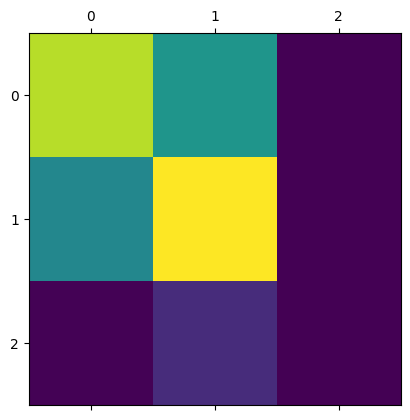

In [42]:
#plt.figure(figsize = (30,30))
plt.matshow(conf_matrix)

In [43]:
df_conf_matrix = pd.DataFrame(conf_matrix, index = [f"Class {i+1}" for i in range(num_classes)],
                  columns = [f"Class {i+1}" for i in range(num_classes)])

img_path = ./image_conf_matrix_15_Class_Normal.rgb.256p.TL.3D.MobileNetV2.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64.png


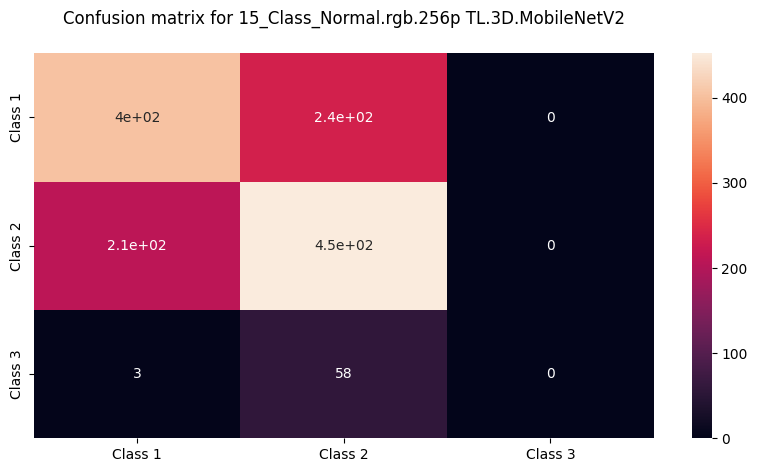

In [44]:
title = "Confusion matrix for "+dataset+" "+impl_type+"\n"
plt.figure(figsize = (10,5))
plt.title(title)
sn.heatmap(df_conf_matrix, annot=True)

img_path = work_dir+'image_conf_matrix_'+checkpointer_name[8:-5]+'.png'
plt.savefig(img_path, dpi=600)
print(f"img_path = {img_path}")

In [45]:
#Confution Matrix and Classification Report

Y_pred = model_loaded.predict_generator(final_test_imageset, len(final_test_imageset))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(sklearn.metrics.confusion_matrix(np_test_label, y_pred))
#'''

NameError: name 'final_test_imageset' is not defined

In [46]:
# Precision [TP/TP+FP] = The ratio of correctly predicted positive observations to the total predicted positive observations.
# Recall (Sensitivity) [TP/TP+FN] = The ratio of correctly predicted positive observations to the all observations in actual class - 'yes'.
# F1 score [F1 Score = 2*(Recall * Precision) / (Recall + Precision)] = The weighted average of Precision and Recall.
# Support = The number of samples of the true response that lie in that class.

print('Classification Report:')
print(sklearn.metrics.classification_report(test_generator.classes, y_pred))
#'''

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.63      0.64       639
           1       0.61      0.68      0.64       662
           2       0.00      0.00      0.00        61

    accuracy                           0.63      1362
   macro avg       0.42      0.44      0.43      1362
weighted avg       0.60      0.63      0.61      1362



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
val_generator.class_indices.keys()

dict_keys(['AD', 'CONTROL', 'PD'])

In [48]:
#'''
print('Classification Report')
print(sklearn.metrics.classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))
#'''

Classification Report
              precision    recall  f1-score   support

          AD       0.65      0.63      0.64       639
     CONTROL       0.61      0.68      0.64       662
          PD       0.00      0.00      0.00        61

    accuracy                           0.63      1362
   macro avg       0.42      0.44      0.43      1362
weighted avg       0.60      0.63      0.61      1362



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
log_data = pd.read_csv(work_dir+log_name, sep=',', engine='python')

In [50]:
# Getting the model history keys
#history.history.keys()
log_data.head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.729456,0.689522,0.636905,0.799538
1,1,0.942773,0.149066,0.500744,2.055718
2,2,0.991891,0.030763,0.536458,1.306516
3,3,0.999220,0.014445,0.540923,1.314891
4,4,0.999844,0.004818,0.540179,1.429207


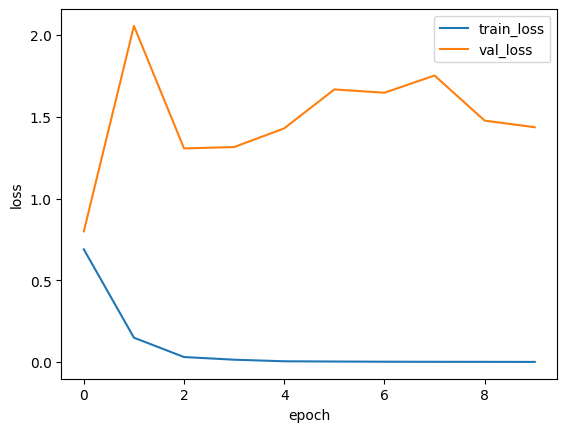

img_path = ./image_vLoss_15_Class_Normal.rgb.256p.TL.3D.MobileNetV2.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64.png


In [51]:
# plot the training artifacts
title = "Val loss for "+dataset+" "+impl_type+"\n"

plt.plot(log_data['loss'])
plt.plot(log_data['val_loss'])
#plt.title(title)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'best')
#plt.grid(b=True, which='major', axis='both')

img_path = work_dir+'image_vLoss_'+checkpointer_name[8:-5]+'.png'
plt.savefig(img_path, dpi=600)
plt.show()
print('img_path =', img_path)

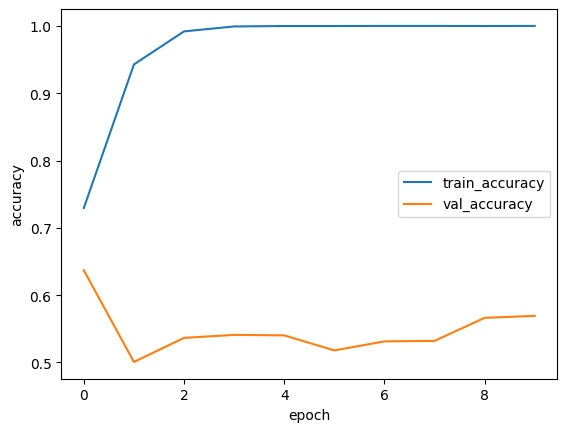

img_path = ./image_vAcc_15_Class_Normal.rgb.256p.TL.3D.MobileNetV2.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64.png


In [52]:
title = "Val acc for "+dataset+" "+impl_type+"\n"

plt.plot(log_data['accuracy'])
plt.plot(log_data['val_accuracy'])
#plt.title(title)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'], loc = 'best')
#plt.grid(b=True, which='major', axis='both')

img_path = work_dir+'image_vAcc_'+checkpointer_name[8:-5]+'.png'
plt.savefig(img_path, dpi=600)
plt.show()
print('img_path =', img_path)

In [ ]:
from IPython.display import FileLink
FileLink(r'/content/best_weights.15_Class_Normal.rgb.256p.TL.3D.ResNet50.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64.hdf5')


/content/best_weights.15_Class_Normal.rgb.256p.TL.3D.ResNet50.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64.hdf5

In [ ]:
while True:
    pass

In [53]:
from sklearn.metrics import accuracy_score,classification_report, roc_auc_score, matthews_corrcoef, hamming_loss, cohen_kappa_score, jaccard_score

y_actual = y_true
y_pred = y_pred

acc = classification_report(y_actual,y_pred,target_names=test_generator.class_indices.keys())
accuracy = accuracy_score(y_actual, y_pred)
mcc = matthews_corrcoef(y_actual, y_pred)
print(f"{acc}")
print(f"Accuracy Score : {accuracy}")
print(f"mcc_score : {mcc}")

hl = hamming_loss(y_actual, y_pred)
print(f"hamming_loss : {hl}")
cks = cohen_kappa_score(y_actual, y_pred)
print(f"cohen_kappa_score : {cks}")
jc = jaccard_score(y_actual, y_pred, average='weighted')
print(f"jaccard_score : {jc}")

              precision    recall  f1-score   support

          AD       0.65      0.63      0.64       639
     CONTROL       0.61      0.68      0.64       662
          PD       0.00      0.00      0.00        61

    accuracy                           0.63      1362
   macro avg       0.42      0.44      0.43      1362
weighted avg       0.60      0.63      0.61      1362

Accuracy Score : 0.6284875183553598
mcc_score : 0.289689274865688
hamming_loss : 0.37151248164464024
cohen_kappa_score : 0.2877445118857038
jaccard_score : 0.4525136271728518


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


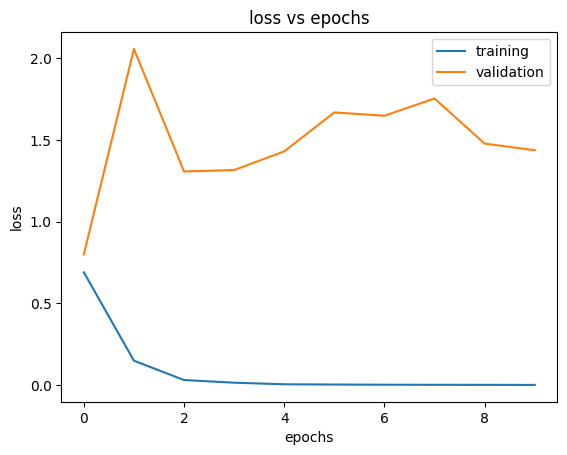

In [54]:
plt.plot(log_data['loss'], label="training")
plt.plot(log_data['val_loss'], label="validation")
plt.title("loss vs epochs")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.savefig('loss_vs_epochs4_latest.png',dpi=1000)

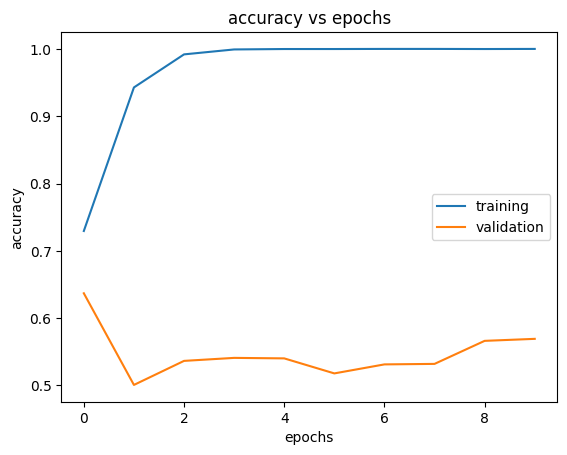

In [55]:
plt.plot(log_data['accuracy'], label="training")
plt.plot(log_data['val_accuracy'], label="validation")
plt.title("accuracy vs epochs")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
#plt.figure(figsize=(19.20,10.80))
plt.savefig('accuracy_vs_epochs4_latest.png',dpi=1000)

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

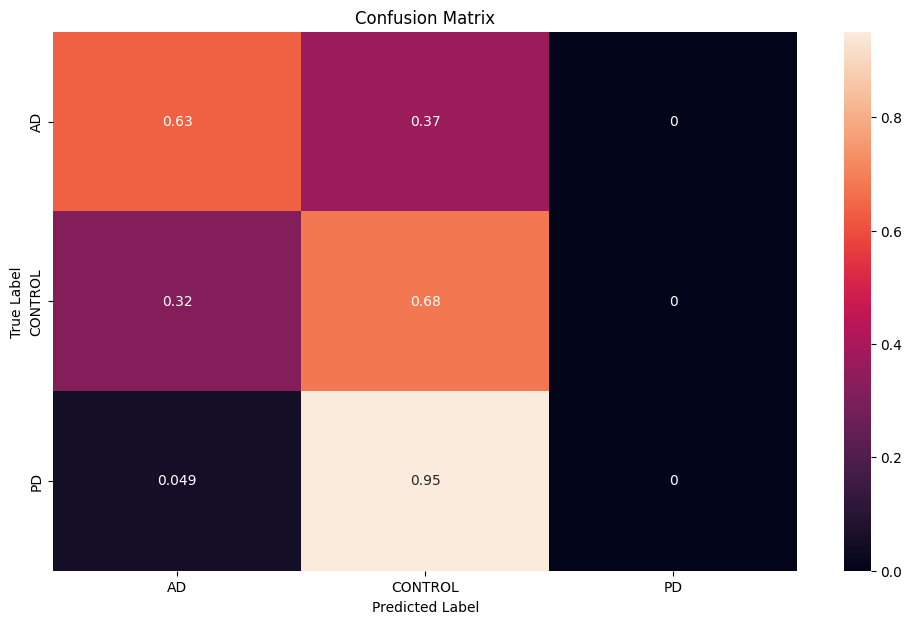

In [57]:
# constant for classes
classes = ('AD', 'CONTROL', 'PD')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
#plt.xticks(rotation=45)
plt.savefig('Confusion_matrix_output_float_latest.png',dpi=1000, bbox_inches='tight')

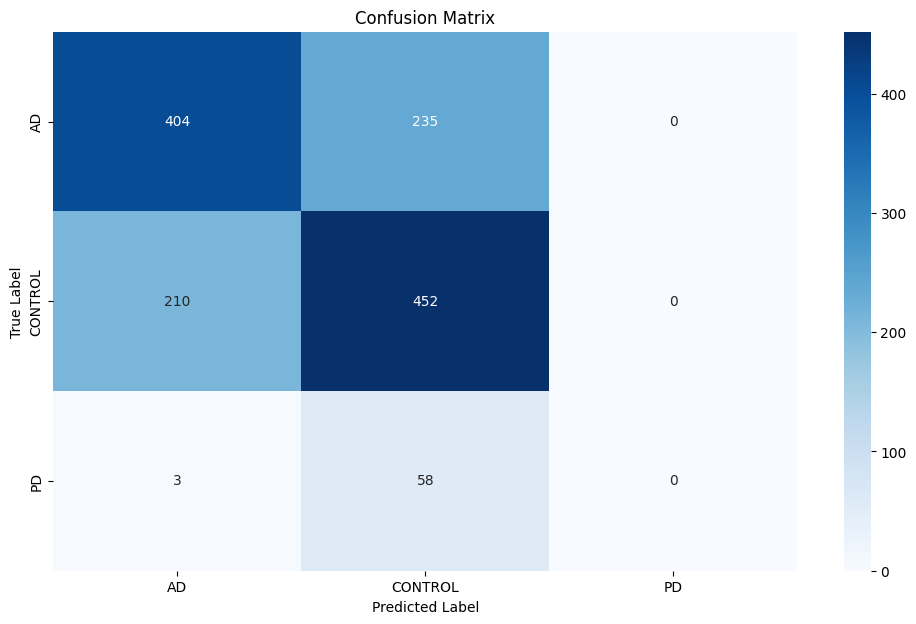

In [58]:
# Plot the confusion matrix using Seaborn heatmap
cf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix, cmap="Blues", annot=True, fmt="d", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig('Confusion_matrix_output_integer_latest.png',dpi=1000, bbox_inches='tight')
plt.show()

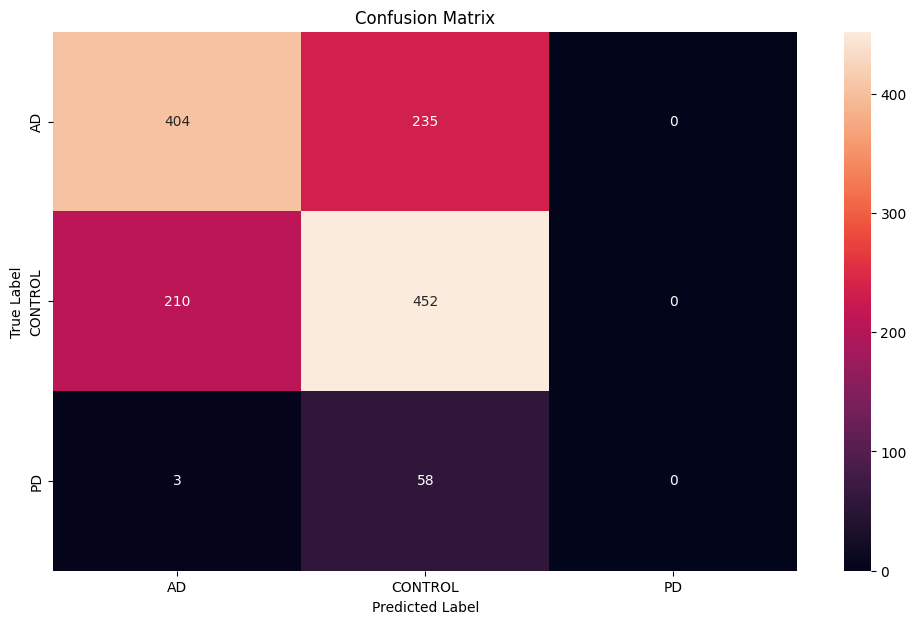

In [59]:
plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig('Confusion_matrix_output_integer_latest.png',dpi=1000, bbox_inches='tight')
plt.show()

In [60]:
def plot_training():
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables

    tr_acc = log_data['accuracy']
    tr_loss = log_data['loss']
    val_acc = log_data['val_accuracy']
    val_loss = log_data['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))

    #plt.subplot(1, 2, 1)
    plt.figure()
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss_vs_epochs5_latest.png',dpi=1000)

    #plt.subplot(1, 2, 2)
    plt.figure()
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('accuracy_vs_epochs5_latest.png',dpi=1000)
    plt.tight_layout
    sn.despine()

<Figure size 2000x800 with 0 Axes>

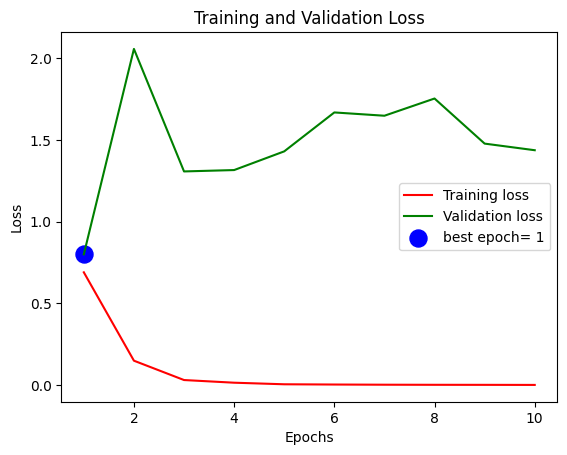

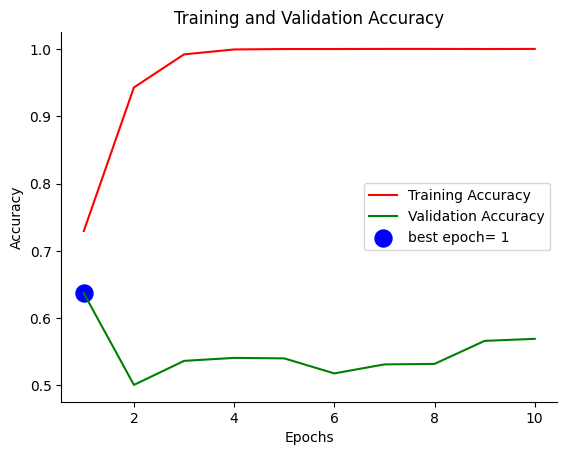

In [61]:
plot_training()

In [ ]:
%cd /kaggle/working

[Errno 2] No such file or directory: '/kaggle/working'
/content


In [ ]:
from IPython.display import FileLink
FileLink(r'best_weights.15_Class_Normal.rgb.256p.TL.3D.ResNet50.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch32.hdf5')

/kaggle/working/best_weights.15_Class_Normal.rgb.256p.TL.3D.ResNet50.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch32.hdf5